In [2]:
!apt install subversion
!svn checkout https://github.com/HSE-LAMBDA/DeepGenerativeModels/trunk/homework/1-AE

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  libapr1 libaprutil1 libserf-1-1 libsvn1
Suggested packages:
  db5.3-util libapache2-mod-svn subversion-tools
The following NEW packages will be installed:
  libapr1 libaprutil1 libserf-1-1 libsvn1 subversion
0 upgraded, 5 newly installed, 0 to remove and 13 not upgraded.
Need to get 2,237 kB of archives.
After this operation, 9,910 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/main amd64 libapr1 amd64 1.6.3-2 [90.9 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/main amd64 libaprutil1 amd64 1.6.1-2 [84.4 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libserf-1-1 amd64 1.3.9-6 [44.4 kB]
Get:4 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libsvn1 amd64 1.9.7-4ubuntu1 [1,183 kB]
Get:5 http://archive.ubuntu.com/ubuntu bionic/universe amd64 subversion amd64 1.9.7-4ubuntu1 

In [3]:
%cd /content/1-AE
!ls

/content/1-AE
autoencoder.py	calculate_fid.py  classifier.py  hw-1.ipynb  omniglot.py


## Важно:

Пожалуйста, поддерживайте ваш код в хорошем состоянии, пишите комментарии, убирайте бесполезные ячейки, пишите модели в специально отведенных модулях. Проверяющие могут **НА СВОЕ УСМОТРЕНИЕ** снижать баллы за:

1. Говнокод
2. Неэффективные решения
3. Вермишель из ячеек в тетрадке
4. Все остальное что им не понравилось

## Важно 2 (0 - 0.3 балла):

За использование логгеров типа wandb/comet/neptune и красивую сборку этой домашки в виде графиков/картинок в этих логгерах мы будем выдавать бонусные баллы. 

## Важно 3:

Решением домашки является архив с использованными тетрадками/модулями, а так же **.pdf файл** с отчетом по проделанной работе по каждому пункту задачи. В нем необходимо описать какие эксперименты вы производили чтобы получить результат который вы получили, а так же обосновать почему вы решили использовать модели которые вы использовали (например denoising AE или sparce AE в пункте 1)




In [4]:
!pip install omniglot
!pip install wandb
!wandb login ee9416edde558c322450d0ec80266d2c0db81f45

  Created wheel for omniglot: filename=omniglot-0.1.0-cp37-none-any.whl size=4043 sha256=632d73337fca295a4994814af623293b9b06fadc0973535052ca04a6d51e81c0
  Stored in directory: /root/.cache/pip/wheels/0f/a4/8f/812bef3525d94ffc71fb9740e007f89e48b9c904f1335243a6
Successfully built omniglot
     |████████████████████████████████| 2.0MB 5.6MB/s 
     |████████████████████████████████| 163kB 50.2MB/s 
     |████████████████████████████████| 102kB 13.5MB/s 
     |████████████████████████████████| 133kB 34.8MB/s 
     |████████████████████████████████| 71kB 11.5MB/s 
  Created wheel for subprocess32: filename=subprocess32-3.5.4-cp37-none-any.whl size=6489 sha256=e02a3ff6b55c3e6105fb694fb1b3aca5b770d06d2d0145e96b70bc4dcabf4996
  Stored in directory: /root/.cache/pip/wheels/68/39/1a/5e402bdfdf004af1786c8b853fd92f8c4a04f22aad179654d1
  Created wheel for pathtools: filename=pathtools-0.1.2-cp37-none-any.whl size=8786 sha256=c6535b9dd14ad910aa80d16b74fe780566e84a95b569e110b9786c2b889b3551
  Stored

In [39]:
import torch
from torch import nn
from torch.nn import functional as F
import numpy as np
from tqdm.notebook import tqdm
import wandb 
import random
import os
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier


import matplotlib.pyplot as plt
%matplotlib inline

OMNIGLOT_CLASSES = 1623
SEED = 1992

В этом домашнем задании мы будем автоэнкодить Omniglot. Omniglot - это датасет в основном для few-shot learning'а, состоящий из рукописных символов из разных существующих и несуществующих (эльфийский, клингонский) языков.

В этом датасете очень много классов, для для каждого класса представлено только 10-20 картинок. Если учить честную классификацию, мы быстро столкнемся с тем, что модель не сможет нормально выучиться.

В этой тетрадке вам предлагается попробовать решить эту проблему - выучить автоэнкодер (любой формы) и, используя латентное его представление, делать классификацию более сложными методами на меньше размерности.

Omniglot очень странно построен, в нем background - это единицы, а не нули. Чтобы перевести это в удобный для нас формат - инвертируем каждый пиксель через нашу кастомную трансформацию - InvertImage


In [6]:
def seed_all(seed=1):
    """
    fixes seeds everywhere
    :param seed: random seed
    """
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    n_gpu = torch.cuda.device_count()
    if n_gpu > 0:
        torch.cuda.manual_seed_all(seed)

seed_all(SEED)

In [7]:
class InvertImage:
    def __call__(self, pic):
        return 1 - pic

    def __repr__(self):
        return self.__class__.__name__ + '()'


In [8]:
from omniglot import FullOmniglot
from torchvision import transforms

from torch.utils.data import DataLoader, Subset

from sklearn.model_selection import train_test_split

data_transforms = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    InvertImage(),
    transforms.Normalize([0.5], [0.5])
])

cuda_num = 0
device = f'cuda:{cuda_num}' if torch.cuda.is_available() else 'cpu'
batch_size = 64


Мы используем кастомный датасет FullOmniglot потому что изначально train/val части омниглота используют разные классы. Мы обьединяем их и делаем свое разбиение

In [10]:
full_dataset = FullOmniglot('./Omniglot', transform=data_transforms, download=True)

labels = []
for _, label in full_dataset:
    labels.append(label)
    
# делаем так, чтобы сплит был сбалансированным по классам
indices_train, indices_test, _, _ = train_test_split(list(range(len(labels))), labels, test_size=0.1, stratify=labels)

train_dataset = Subset(full_dataset, indices=indices_train)
test_dataset = Subset(full_dataset, indices=indices_test)

train_loader = DataLoader(train_dataset, batch_size=batch_size, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, drop_last=True)


Extracting ./Omniglot/omniglot-py/images_background.zip to ./Omniglot/omniglot-py



Extracting ./Omniglot/omniglot-py/images_evaluation.zip to ./Omniglot/omniglot-py



In [11]:
def process_image(image):
    return (image.squeeze().detach().to('cpu') + 1) / 2

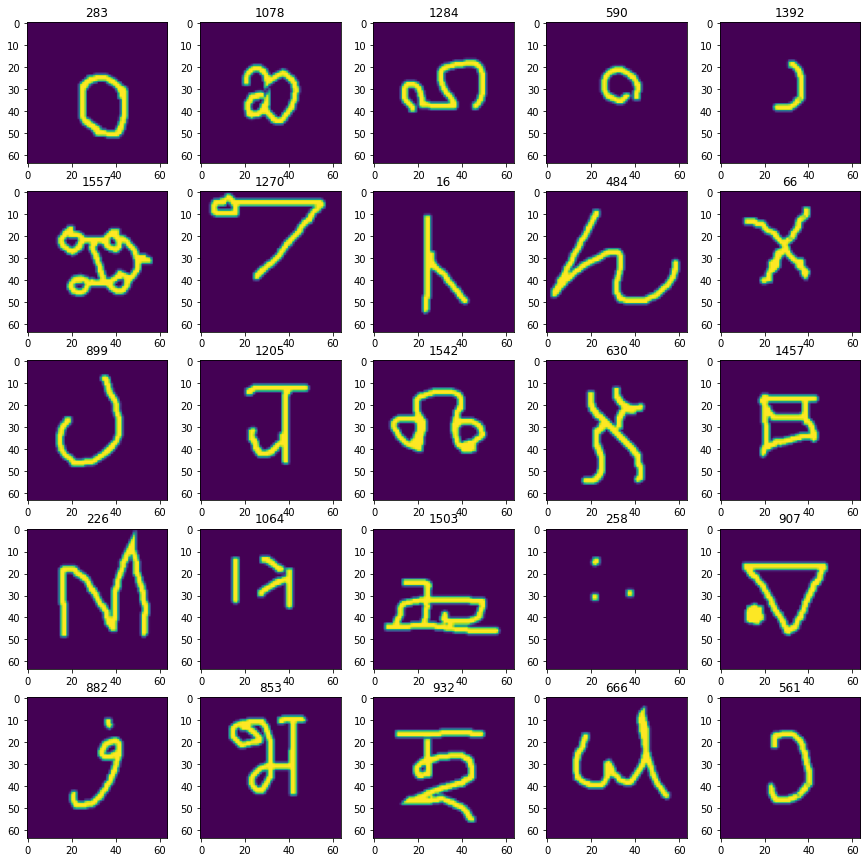

In [12]:
test_batch = next(iter(train_loader))


plt.figure(figsize=(15, 15))
for ind, (image, label) in enumerate(zip(*test_batch)):
    if ind >= 25: break
    plt.subplot(5, 5, ind+1)
    plt.imshow(process_image(image))
    plt.title(label.item())
plt.show()
    

### Задача 1 (0.3 балла):

Написать свой автоэнкодер, доучить его до приличного качества

Для того чтобы писать красивый код и не делать тетрадку слишком длинной предлагается писать свои модели в отдельном модуле, см `./autoencoder.py`

In [13]:
!ls

autoencoder.py	  classifier.py  Omniglot     __pycache__
calculate_fid.py  hw-1.ipynb	 omniglot.py


In [14]:
%load_ext autoreload
%autoreload 2

In [21]:
from autoencoder import AutoEncoder

hidden = 64
 
wandb.init(project='gen models hw1', name=f'AE MSE big, hidden={hidden}')
ae = AutoEncoder(hidden).to(device)
wandb.watch(ae)
optim = torch.optim.Adam(ae.parameters(), lr=5e-3)

train/loss,0.15246
step,56
_runtime,616
_timestamp,1614273366
_step,1427
test/loss,0.17969
epoch,2


train/loss,█▅▅▄▄▄▄▃▄▄▂▄▃▃▂▃▂▂▂▂▂▂▂▂▃▃▂▂▁▂▂▂▂▁▂▃▂▂▂▁
step,▁▂▂▃▃▄▄▅▆▆▇▇█▁▂▂▃▃▄▅▅▆▆▇▇█▁▂▃▃▄▄▅▅▆▆▇█▁▂
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
test/loss,█▃▁
epoch,▁▅█


In [23]:
#checkpoint = torch.load('checkpoint.pt')
#ae.load_state_dict(checkpoint['model_state_dict'])

Классический трейнлуп:

Note: я буду уважать вас сильнее если вместо вывода графика в тетрадку вы будете логгировать все (лоссы + картинки) в wandb/comet/neptune. И так далее по ходу тетрадки тоже

In [24]:
 sum(p.numel() for p in ae.parameters())

4098689

In [25]:
criterion = torch.nn.MSELoss()
epochs = 50

for epoch in tqdm(range(epochs)):
    ae.train()
    for step, (image, _) in enumerate(train_loader):
        input_img = image.to(device)
        output_img = ae(input_img)
        mse_loss = criterion(output_img, input_img)
        wandb.log({'train/loss': mse_loss.item(), 'step': step})
        mse_loss.backward()
        optim.step()
        optim.zero_grad()
    ae.eval()
    test_loss = 0
    for step, (image, _) in enumerate(test_loader):
        input_img = image.to(device)
        with torch.no_grad():
            output_img = ae(input_img)
        mse_loss = criterion(output_img, input_img)
        test_loss += mse_loss.item()
    num_images = 4
    wandb.log({'test/loss': test_loss / len(test_loader), 'epoch': epoch,
               "test/input": [wandb.Image(input_img[i].detach().cpu().numpy(), 
                                          caption=f"epoch {epoch}") for i in range(num_images)],
               "test/output": [wandb.Image(output_img[i].detach().cpu().numpy(), 
                                          caption=f"epoch {epoch}") for i in range(num_images) ]})
    
checkpoint = f'checkpoint_{hidden}.pt'
torch.save({
            'model_state_dict': ae.state_dict(),
            'optimizer_state_dict': optim.state_dict(),
        }, checkpoint)

64


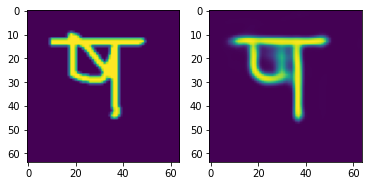

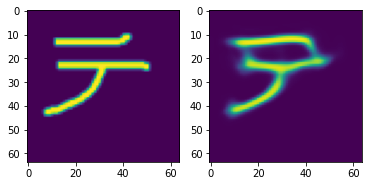

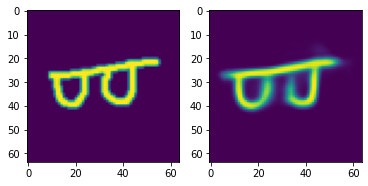

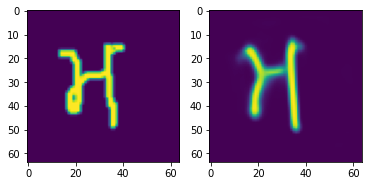

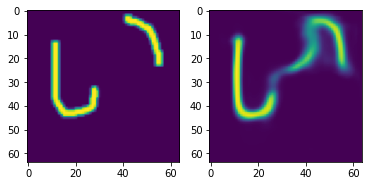

In [ ]:
test_batch = next(iter(test_loader))
print(len(test_batch[0]))
ae.eval()

for image in test_batch[0][:5]:
    plt.subplot(1, 2, 1)
    plt.imshow(image.squeeze())
    plt.subplot(1, 2, 2)
    plt.imshow(ae(image.unsqueeze(0).to(device)).squeeze().detach().to('cpu'))
    plt.show()

Мало посмотреть на результаты глазами, надо еще посчитать метрики качества.

Для этой задачи не очень хочется использовать FID с Inception обученными на ImageNet'е, поэтому предлагается обучить свою модель классификации на MNIST

Это можно сделать здесь (только красиво) или вынести в отдельную тетрадку/файлы

### Задача 2 (0.3 балла):

Научить внешний классификатор классифицировать MNIST, использовать его в подсчете FID между реальным Omniglot и выходами автоэнкодера

In [14]:
from torchvision.datasets import MNIST

mnist_transforms = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

mnist_train_dataset = MNIST('./MNIST', train=True, transform=mnist_transforms, download=True)
mnist_train_loader = DataLoader(mnist_train_dataset, batch_size=batch_size, drop_last=True, shuffle=True)
mnist_test_dataset = MNIST('./MNIST', train=False, transform=mnist_transforms, download=True)
mnist_test_loader = DataLoader(mnist_test_dataset, batch_size=batch_size, drop_last=True, shuffle=True)

In [23]:
from classifier import Classifier

clf = Classifier().to(device)
optim = torch.optim.Adam(clf.parameters(), lr=0.001)
criterion = torch.nn.CrossEntropyLoss()
wandb.init(project='gen models hw1', name=f'MNIST classifier')

train/loss,0.00437
step,936
_runtime,450
_timestamp,1614259033
_step,15006
test/loss,0.02789
epoch,14


train/loss,█▃▃▂▆▄▁▂▁▂▅▄▂▃▁▄▃▁▃▂▁▂▄▁▁▁▁▂▁▃▃▂▁▁▁▁▁▁▁▁
step,▂▄▇▃▆▁▄▇▃▆▂▅█▃▆▂▅█▄▇▂▅▁▄▇▃▆▁▄▇▃▆▂▅█▃▆▂▅█
_runtime,▁▁▁▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
test/loss,▄█▂▂▃▄▂▃▂▁▂▁▃▂▃
epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█


In [24]:
epochs = 10

for epoch in tqdm(range(epochs)):
    clf.train()
    for step, (image, lbl) in enumerate(mnist_train_loader):
        input_img = image.to(device)
        lbl = lbl.to(device, non_blocking=True)
        pred = clf(input_img)
        ce_loss = criterion(pred, lbl)
        wandb.log({'train/mnist_cls_loss': ce_loss.item(), 'step': step})
        ce_loss.backward()
        optim.step()
        optim.zero_grad()
    clf.eval()
    test_loss = 0
    for step, (image, lbl) in enumerate(mnist_test_loader):
        input_img = image.to(device)
        lbl = lbl.to(device, non_blocking=True)
        with torch.no_grad():
            pred = clf(input_img)
        ce_loss = criterion(pred, lbl)
        test_loss += ce_loss.item()
    num_images = 4
    wandb.log({'test/mnist_cls_loss': test_loss / len(mnist_test_loader), 'epoch': epoch,
               "test/input": [wandb.Image(input_img[i].detach().cpu().numpy(), 
                                          caption=f"label {lbl[i]}") for i in range(num_images)]})
    
checkpoint = 'clf.pt'
torch.save({
            'model_state_dict': clf.state_dict(),
            'optimizer_state_dict': optim.state_dict(),
        }, checkpoint)

In [28]:
from classifier import Classifier
clf = Classifier().to(device)
checkpoint = torch.load('clf.pt')
clf.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

In [29]:
from calculate_fid import calculate_fid

print(f"FID for AE: {calculate_fid(test_loader, ae, clf)}")

FID for AE: 0.060711067663993035


In [30]:
class NoiseRecoModel(nn.Module):
    def __init__(self, intensivity=0.1):
        super().__init__()
        # self.placeholder_layer
        # ненужный слой, который позвоняет в calculate_fid смотреть на каком девайсе расположена сетка
        self.placeholder_layer = nn.Linear(1, 1)
        self.intensivity = intensivity
        
    def forward(self, x):
        return x + torch.rand_like(x) * self.intensivity

Проверим насколько наша метрика стабильна: чем больше шум, тем больше она должна становиться

In [31]:
for noise_level in [0.001, 0.01, 0.05, 0.1, 0.5, 0.7, 1.]:
    noise_model = NoiseRecoModel(noise_level).to(device)
    print(f"FID for noise {noise_level}: {calculate_fid(test_loader, noise_model, clf)}")

FID for noise 0.001: 6.39373983757352e-07
FID for noise 0.01: 7.388097999094789e-05
FID for noise 0.05: 0.0020159928466061405
FID for noise 0.1: 0.01113855739427505
FID for noise 0.5: 0.33442287264566906
FID for noise 0.7: 0.4387127508662392
FID for noise 1.0: 0.5883663218387643


Понятно что сам по себе автоэнкодер - такая себе генеративная модель, хоть ее и можно использовать в таком качестве

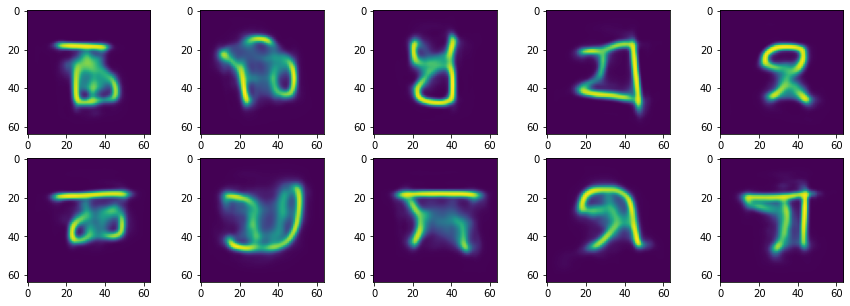

In [32]:
ae.eval()

test_images = next(iter(test_loader))[0].to(device)
images_latent = ae.get_latent_features(test_images).to('cpu')

test_noise = torch.randn_like(images_latent) * 0.9
sampled_mnist = ae.decoder(test_noise.to(device)).to('cpu')
    
plt.figure(figsize=(15, 5))
for ind in range(10):
    plt.subplot(2, 5, ind+1)
    plt.imshow(sampled_mnist[ind].squeeze().detach())


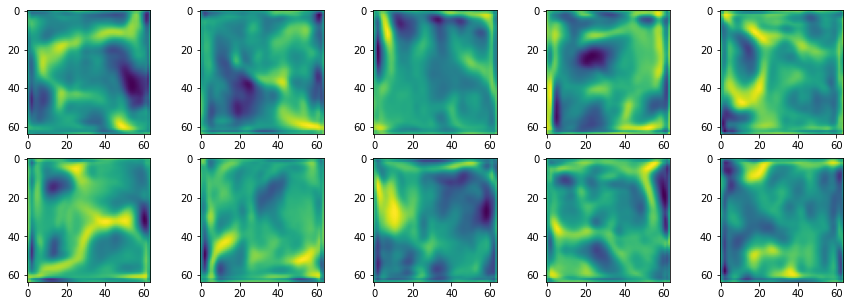

In [ ]:
ae.eval()

test_images = next(iter(test_loader))[0].to(device)
images_latent = ae.get_latent_features(test_images).to('cpu')

test_noise = torch.randn_like(images_latent) * 0.9
sampled_mnist = ae.decoder(test_noise.to(device)).to('cpu')
    
plt.figure(figsize=(15, 5))
for ind in range(10):
    plt.subplot(2, 5, ind+1)
    plt.imshow(sampled_mnist[ind].squeeze().detach())


Мы предлагаем использовать латентные фичи из AE для классификации.

Главная проблема классификации на Omniglot в том, что классов очень много и обычные классификаторы не могут справиться:

### Задача 3 (0.2 балла):

Попробовать честную классификацию на Omniglot, довести ее до приличного качества.

In [20]:
from classifier import Classifier
OMNIGLOT_CLASSES = 1623

wandb.init(project='gen models hw1', name=f'MNIST classifier')
clf = Classifier(n_classes=OMNIGLOT_CLASSES, mode='omniglot').to(device)
wandb.watch(clf)
optim = torch.optim.Adam(clf.parameters(), lr=0.001)
criterion = torch.nn.CrossEntropyLoss()

In [21]:
epochs = 25

b_sz = batch_size
train_examples = len(train_loader) * b_sz
test_examples = len(test_loader) * b_sz
train_pred_lbls, train_lbls = torch.zeros(train_examples), torch.zeros(train_examples)
test_pred_lbls, test_lbls = torch.zeros(test_examples), torch.zeros(test_examples)
for epoch in tqdm(range(epochs)):
    clf.train()
    for step, (image, lbl) in enumerate(train_loader):
        input_img = image.to(device)
        lbl = lbl.to(device, non_blocking=True)
        pred = clf(input_img)
        train_pred_lbls[step * b_sz: (step + 1) * b_sz] = pred.argmax(dim=-1).detach().cpu()
        train_lbls[step * b_sz: (step + 1) * b_sz] = lbl.cpu()
        ce_loss = criterion(pred, lbl)
        wandb.log({'train/omniglot_cls_loss': ce_loss.item()})
        ce_loss.backward()
        optim.step()
        optim.zero_grad()
    wandb.log({'train/accuracy': (train_pred_lbls == train_lbls).float().mean()})
    clf.eval()
    test_loss = 0
    for step, (image, lbl) in enumerate(test_loader):
        input_img = image.to(device)
        lbl = lbl.to(device, non_blocking=True)
        with torch.no_grad():
            pred = clf(input_img)
        test_pred_lbls[step * b_sz: (step + 1) * b_sz] = pred.argmax(dim=-1).cpu()
        test_lbls[step * b_sz: (step + 1) * b_sz] = lbl.cpu()
        ce_loss = criterion(pred, lbl)
        test_loss += ce_loss.item()
    
    num_images = 4
    wandb.log({'test/omniglot_cls_loss': test_loss / len(test_loader), 'epoch': epoch,
               "test/input": [wandb.Image(input_img[i].detach().cpu().numpy(), 
                                          caption=f"label {lbl[i]}") for i in range(num_images)],
               'test/accuracy': (test_pred_lbls == test_lbls).float().mean()})
print(f"random accuracy: {1/OMNIGLOT_CLASSES}")
print(f"CNN accuracy: {(test_pred_lbls == test_lbls).float().mean()}")
checkpoint = 'omniglot_clf.pt'
torch.save({
            'model_state_dict': clf.state_dict(),
            'optimizer_state_dict': optim.state_dict(),
        }, checkpoint)


random accuracy: 0.0006161429451632779
CNN accuracy: 0.7106249928474426


Возможное решение проблемы с классификацией - обработка данный автоэнкодером и использование преобразованных латентных фичей вместо картинок.

Латентные фичи можно представить в виде табличных 1D данных, на которых можно учить даже разные бустинги.


### Задача 4 (0.2 балла):

Получить латентные представления от картинок в Omniglot, выучить любую (хорошую) модель классификации на них до адекватного качества.

note: не забывайте учить на трейне, а считать аккураси на тесте

In [33]:
from lightgbm import LGBMClassifier

b_sz = batch_size
train_examples = len(train_loader) * b_sz
test_examples = len(test_loader) * b_sz
X_train, y_train = np.zeros((train_examples, ae.hidden_size)), np.zeros(train_examples)
X_test, y_test = np.zeros((train_examples, ae.hidden_size)), np.zeros(train_examples)

ae.eval()
for i, (image, lbl) in enumerate(train_loader):
    input_img = image.to(device)
    with torch.no_grad():
        hidden = ae.get_latent_features(input_img).view(b_sz, -1)
    X_train[i * b_sz: (i + 1) * b_sz] = hidden.cpu().numpy()
    y_train[i * b_sz: (i + 1) * b_sz] = lbl.numpy()

for i, (image, lbl) in enumerate(test_loader):
    input_img = image.to(device)
    with torch.no_grad():
        hidden = ae.get_latent_features(input_img).view(b_sz,  -1)
        X_test[i * b_sz: (i + 1) * b_sz] = hidden.cpu().numpy()
        y_test[i * b_sz: (i + 1) * b_sz] = lbl.numpy()

In [21]:
clf = LGBMClassifier(n_estimators=500)
clf.fit(X_train, y_train);

In [22]:
pred = clf.predict(X_test)

In [23]:
print(f"random accuracy: {1/OMNIGLOT_CLASSES:.4f}")
print(f"xgboost + AE accuracy: {accuracy_score(y_test, pred):.4f}")

random accuracy: 0.0006
xgboost + AE accuracy: 0.0110


In [40]:
clf = LinearSVC(max_iter=5000)
clf.fit(X_train, y_train)  
pred = clf.predict(X_test)
print(f"random accuracy: {1/OMNIGLOT_CLASSES:.4f}")
print(f"SVC + AE accuracy: {accuracy_score(y_test, pred):.4f}")

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


random accuracy: 0.0006
SVC + AE accuracy: 0.0438


In [43]:
clf = LogisticRegression(max_iter=5000)
clf.fit(X_train, y_train)  
pred = clf.predict(X_test)
print(f"random accuracy: {1/OMNIGLOT_CLASSES:.4f}")
print(f"log reg + AE accuracy: {accuracy_score(y_test, pred):.4f}")

random accuracy: 0.0006
log reg + AE accuracy: 0.0493


In [42]:
clf = KNeighborsClassifier()
clf.fit(X_train, y_train)  
pred = clf.predict(X_test)
print(f"random accuracy: {1/OMNIGLOT_CLASSES:.4f}")
print(f"knn + AE accuracy: {accuracy_score(y_test, pred):.4f}")

random accuracy: 0.0006
knn + AE accuracy: 0.0365
